In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train_data = pd.read_csv('../input/digit-recognizer/train.csv')
test_data = pd.read_csv('../input/digit-recognizer/test.csv')

In [3]:
train_data.head

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

In [4]:
train_data.shape, test_data.shape

((42000, 785), (28000, 784))

In [5]:
y = train_data['label']
x = train_data.drop(['label'], axis=1, inplace=True)

In [6]:
train_data = train_data.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)
train_data.shape, test_data.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

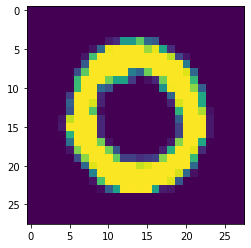

In [7]:
import matplotlib.pyplot as plt
plt.imshow(train_data[1])

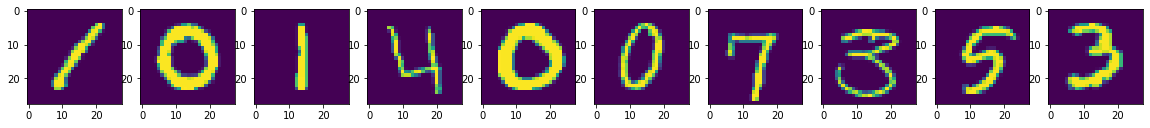

In [8]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(train_data[i])

In [9]:
train = np.array(train_data)
y = np.array(y)
test = np.array(test_data)

In [10]:
train.shape

(42000, 28, 28, 1)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'digit count')

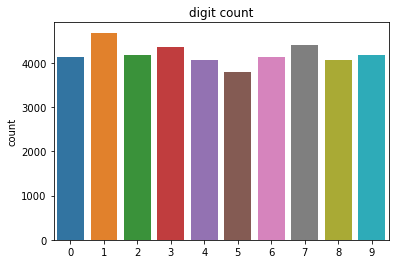

In [11]:
import seaborn as sns
sns.countplot(y)
plt.title('digit count')

In [12]:
from keras.utils.np_utils import to_categorical
y = to_categorical(y,num_classes=10) # it will do suppose y=4 ---> [0,0,0,0,1,0,0,0,0,0]

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train, y, test_size = 0.2, random_state = 42)


In [14]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rescale = 1./255,
                              rotation_range=15,
                              width_shift_range=0.03,
                              height_shift_range=0.03,
                              shear_range=0.15,
                              fill_mode='nearest')
train_generator = data_gen.flow(x_train, y_train, batch_size=64)
val_generator = data_gen.flow(x_val, y_val, batch_size=64)

In [15]:
from keras import layers, models, optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.models import Sequential

In [16]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 3, strides=(1,1), padding='Same', activation='relu', input_shape = [28,28,1]))
model.add(Conv2D(filters = 64, kernel_size = 3, strides=(2,2), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = 3, strides=(1,1), padding='Same', activation='relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, strides=(2,2), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(10, activation="softmax"))


In [17]:
optimizer = optimizers.Adam(learning_rate=0.0001)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [19]:
batch_size=64
import keras
es_callback = keras.callbacks.EarlyStopping(monitor ='val_accuracy', patience = 10, mode = 'max', restore_best_weights = True)
reducelr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00000001)

history = model.fit_generator(train_generator, 
                             steps_per_epoch = len(x_train)//batch_size,
                             epochs=60,
                             validation_data = val_generator,
                             validation_steps = len(x_val)//batch_size,
                             callbacks = [es_callback, reducelr_callback])


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
525/525 [==============================] - 16s 25ms/step - loss: 1.6388 - accuracy: 0.4347 - val_loss: 0.3684 - val_accuracy: 0.8825
Epoch 2/60
525/525 [==============================] - 12s 22ms/step - loss: 0.4890 - accuracy: 0.8439 - val_loss: 0.2321 - val_accuracy: 0.9266
Epoch 3/60
525/525 [==============================] - 12s 22ms/step - loss: 0.3398 - accuracy: 0.8932 - val_loss: 0.1690 - val_accuracy: 0.9474
Epoch 4/60
525/525 [==============================] - 12s 23ms/step - loss: 0.2434 - accuracy: 0.9259 - val_loss: 0.1257 - val_accuracy: 0.9630
Epoch 5/60
525/525 [==============================] - 12s 22ms/step - loss: 0.2033 - accuracy: 0.9393 - val_loss: 0.1129 - val_accuracy: 0.9658
Epoch 6/60
525/525 [==============================] - 12s 23ms/step - loss: 0.1740 - accuracy: 0.9485 - val_loss: 0.0987 - val_accuracy: 0.9713
Epoch 7/60
525/525 [==============================] - 12s 22ms/step - loss: 0.1520 - accuracy: 0.9558 - val_loss: 0.0868 - val_accuracy:

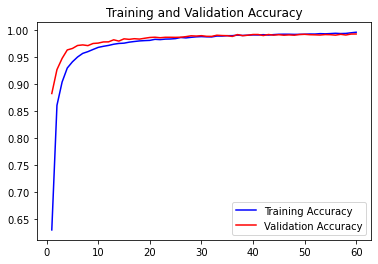

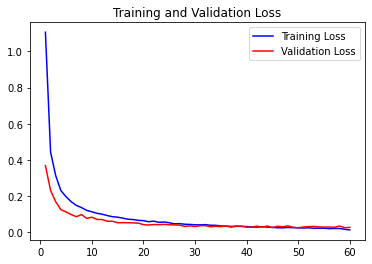

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

ep = range(1,len(acc) + 1)

#Train and Validation accuracy
plt.plot(ep, acc, 'b', label='Training Accuracy')
plt.plot(ep, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

#Train and Validation loss
plt.plot(ep, loss, 'b', label='Training Loss')
plt.plot(ep, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [21]:
y_result = model.predict(test)
print('Prediction Shape is {}'.format(y_result.shape))

Prediction Shape is (28000, 10)


In [22]:
results = np.argmax(y_result, axis=1)
results = pd.Series(results,name="Label")

In [23]:
My_submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

My_submission.to_csv("submission.csv",index=False)